In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scIB

sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
import warnings
warnings.filterwarnings('ignore')

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
import rpy2.robjects as ro
import anndata2ri

In [3]:
plt.rcParams['figure.figsize'] = 8,8

In [4]:
adata_file = "/home/icb/daniel.strobl/scanorama.h5ad"
adata = sc.read(adata_file, cache=True)

In [5]:
scIB.preprocessing.reduce_data(adata, hvg=True, pca=True, umap=True)

HVG
Computed 4000 highly variable genes
PCA
Nearest Neigbours
UMAP


In [6]:
adata.obs['cell_type'] = adata.obs['cell_ontology_class']

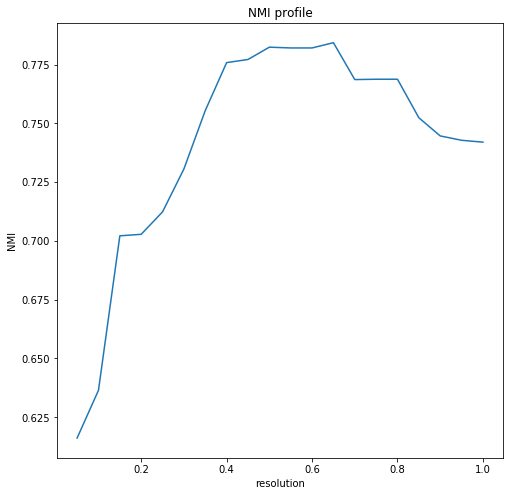

In [7]:
opt_clus = scIB.clustering.opt_louvain(adata, label='cell_type', plot=True, force=True, verbose=True)

In [8]:
opt_clus[0:2]

(0.65, 0.7843295804243648)

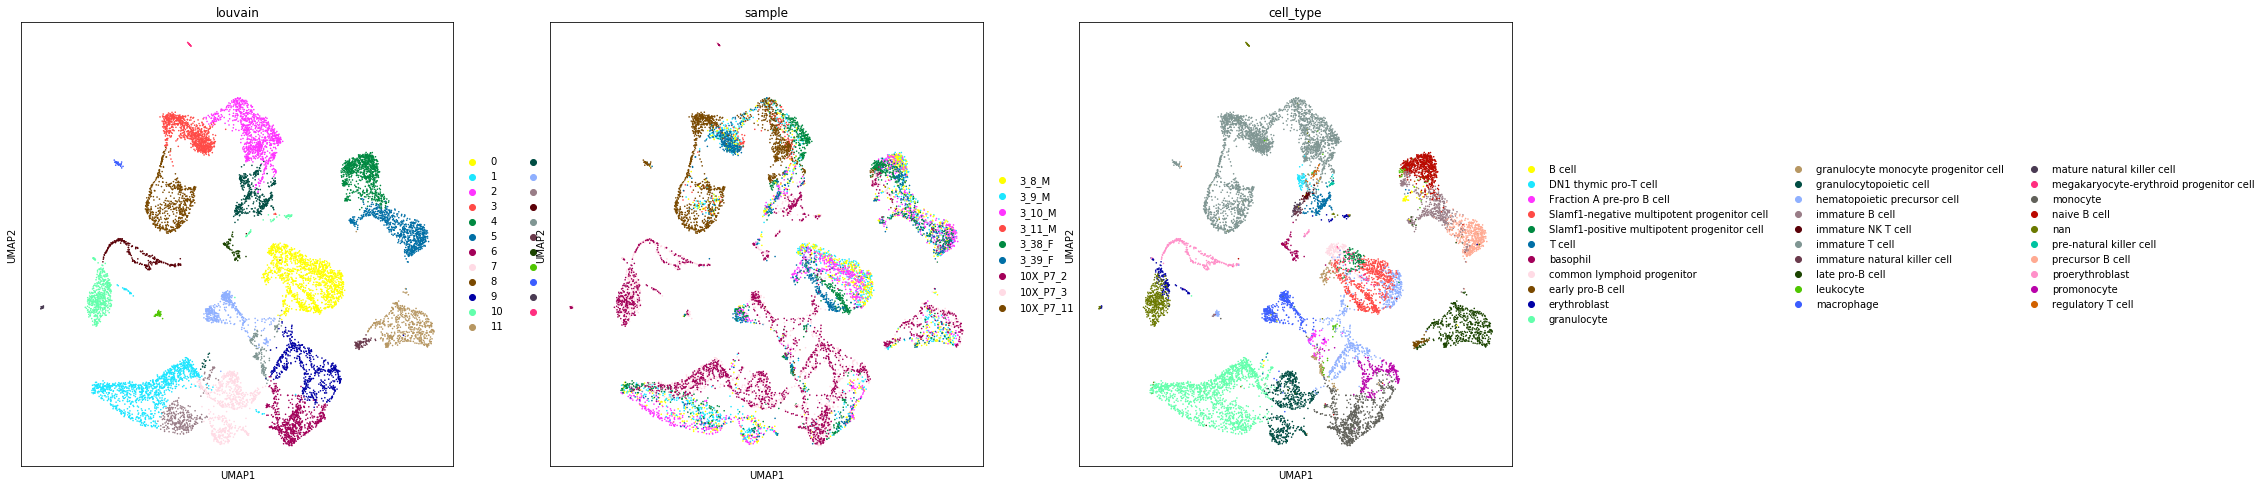

In [19]:
sc.pl.umap(adata, color=['louvain', 'sample', 'cell_type'], palette=sc.pl.palettes.godsnot_64)

## kBET

In [10]:
kbet_scores = scIB.metrics.kBET(adata, adata.X, covariate_key='sample', cluster_key='cell_type',
                  hvg=True, heuristic=False, verbose=False)
kbet_scores

,kBET
cluster,
immature T cell,0.001625
nan,0.996204
DN1 thymic pro-T cell,1.000000
leukocyte,1.000000
immature B cell,0.946966
late pro-B cell,0.998584
precursor B cell,0.940538
macrophage,0.000000
naive B cell,0.591870


In [14]:
adata_file = "/home/icb/daniel.strobl/Masterinternship_2019/group_malte/tabula_muris/data/"
adata_raw = sc.read(adata_file, cache=True)

In [16]:
adata.shape

(11842, 12914)

In [18]:
scIB.metrics.kBET_comparison(adata, adata.X, adata.X,
                             covariate_key='sample', cluster_key='cell_type',
                             hvg=True, heuristic=False, verbose=False)

,kBET_before,kBET_after,difference
cluster,,,
immature T cell,0.000472,0.000472,0.0
nan,0.998706,0.998706,0.0
DN1 thymic pro-T cell,1.000000,1.000000,0.0
leukocyte,1.000000,1.000000,0.0
immature B cell,0.887217,0.887217,0.0
late pro-B cell,0.997548,0.997548,0.0
precursor B cell,0.979411,0.979411,0.0
macrophage,0.999877,0.999877,0.0
naive B cell,0.529454,0.529454,0.0


### Trying Function Code

In [6]:
anndata2ri.activate()

In [7]:
ro.r("library(kBET)")
ro.globalenv['data_mtrx'] = adata.X
ro.globalenv['batch'] = adata.obs['cell_type']

In [8]:
batch_estimate = ro.r("batch.estimate <- kBET(data_mtrx, batch)")
batch_estimate

summary,[RTYPES.VECSXP]
results,[RTYPES.VECSXP]
average.pval,[RTYPES.REALSXP]
stats,[RTYPES.VECSXP]
params,[RTYPES.VECSXP]
outsider,[RTYPES.VECSXP]


In [9]:
ro.r("names(batch.estimate)")

[1] "summary"      "results"      "average.pval" "stats"        "params"      
[6] "outsider"    


array(['summary', 'results', 'average.pval', 'stats', 'params',
       'outsider'], dtype='<U12')

In [12]:
ro.r("batch.estimate$average.pval")[0]

5.825127962211241e-07

In [10]:
anndata2ri.deactivate()

## PC Regression

In [10]:
n_comps = min(sum(adata.var["highly_variable"] == True), adata.n_obs)
n_comps

1090

In [11]:
hvg = (adata.var["highly_variable"] == True)
np.where(hvg)[0]

array([    2,    12,    24, ..., 18380, 18390, 18391])

In [12]:
mtx = adata.X[:, np.where(hvg)[0]]
mtx.shape

(1090, 4000)

In [13]:
adata_pca = sc.tl.pca(mtx, n_comps=n_comps, use_highly_variable=False, return_info=True, svd_solver='full', copy=True)

computing PCA with n_comps = 1090
    finished (0:00:02.11)


In [20]:
[a.shape for a in adata_pca]

[(1090, 1090), (1090, 4000), (1090,), (1090,)]

In [55]:
adata_pca.uns["pca"]

{'variance': array([5.89201293e+02, 4.04977216e+02, 2.82605030e+02, ...,
        3.44458961e-01, 3.35927732e-01, 2.95869152e-27]),
 'variance_ratio': array([9.56515219e-02, 6.57444026e-02, 4.58783806e-02, ...,
        5.59198090e-05, 5.45348409e-05, 4.80316913e-31])}

In [17]:
anndata2ri.activate()

In [46]:
ro.globalenv["X_pca"] = adata_pca.obsm["X_pca"]
ro.globalenv["pca_var"] = adata_pca.uns["pca"]["variance"]
ro.r("pca.data <- list(x=X_pca, sdev=pca_var)")

x,[RTYPES.REALSXP]
sdev,[RTYPES.REALSXP]


In [49]:
# ro.r("batch.silhouette <- batch_sil(pca.data, batch)")
pcr = ro.r("batch.pca <- pcRegression(pca.data, batch, n_top=100)")

In [50]:
pca_regression = dict(zip(pcr.names, list(pcr)))
pca_regression

{'maxVar': array([12.2,  0.4,  0.3,  0.3]),
 'PmaxVar': array([1.e-16, 1.e-16, 1.e-16, 1.e-16]),
 'pcNfrac': array([0.08]),
 'pcRegscale': array([0.42215256]),
 'maxCorr': array([0.97469739]),
 'maxR2': array([0.950035]),
 'msigPC': array([0.99]),
 'maxsigPC': array([0.98]),
 'R2Var': array([0.85679433]),
 'ExplainedVar': array([52.8, 25. , 12.2, ...,  0. ,  0. ,  0. ]),
 'r2': array([[9.50035000e-01, 6.46398043e-03, 1.00000000e-16],
        [9.02345507e-01, 3.62229185e-04, 1.00000000e-16],
        [9.42015453e-01, 1.00000000e-16, 1.00000000e-16],
        ...,
        [2.37033593e-04, 9.39176400e-01, 9.98369477e-01],
        [1.03881384e-04, 8.85181416e-01, 9.99781796e-01],
        [4.98968749e-01, 9.98400059e-01, 6.65684392e-01]])}

In [12]:
pca_regression['pcRegscale'][0]

0.6601307189542484

In [7]:
anndata2ri.deactivate()